<left><img src="https://i.ibb.co/zWjkHsWJ/marca-final-rgb-campanha-2025-versao02.png" width="35%" height="35%"></left>

# Tópicos em Matemática Aplicada: Deep Learning (Aula 06)

Data: 18/set/25


---
## Introdução

**Objetivo:** resolver o problema de classificação de um objeto do dataset CIFAR-10 construindo uma rede neural convolucional com o Keras / Pytorch.

* Este dataset contém 60 mil imagens coloridas distribuídas em 10 classes distintas: avião, carro, pássaro, gato, veado, cachorro, sapo, cavalo, barco, caminhão.

* As 60 mil imagens são distribuídas em 50 mil para treino e 10 mil para teste.

---

Começamos avisando que queremos usar o *backend* Pytorch.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

---
Assim como nos demais exemplos, começamos importando as bibliotecas necessárias para o trabalho. Aqui estamos importando o `Keras`, `pyplot`, `scikit-learn` e `seaborn`.

Perceba que estamos chamando métodos novos como: `Dropout` e `BatchNormalization`.

In [2]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras import datasets, layers, models
from keras.utils import to_categorical
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

---
O CIFAR-10 também é parte do `Keras`, logo para carregar as imagens de treino e teste basta usar o método `load_data()`.

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


---
Vamos analisar a estrutura dos dados que carregamos

In [4]:
# Checando os tensores
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


Note que as imagens agora são ligeiramente maiores do que aquelas do MNIST, elas tem dimensão $32\times 32$. Um outro detalhe, as imagens são coloridas. Nesta situação cada imagem é formada por 3 matrizes, uma contendo a intensidade luminosa do vermelho, outra do verde e outra do azul (RGB).

---

Agora precisamos verificar quais são os rótulos de cada tipo de imagem. Neste caso são numéricos também. Isso nos sugere que devemos transformá-los também para o formato categórico.

In [5]:
# Verificando as etiquetas únicas
print(np.unique(train_labels))
print(np.unique(test_labels))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


---
Agora vamos criar os rótulos (palavras) que serão associados às classes numéricas.

As classes estão organizadas em ordem alfabética com seus respectivos nomes em inglês. Mais detalhes sobre o CIFAR10, você pode encontrar em [https://www.cs.toronto.edu/~kriz/cifar.html](https://https://www.cs.toronto.edu/~kriz/cifar.html).

In [6]:
# Criando a lista das etiquetas
class_names = ['avião', 'carro', 'pássaro', 'gato', 'veado',
               'cachorro', 'sapo', 'cavalo', 'barco', 'caminhão']

---
Não custa nada dar uma olhadinha nas imagens e nos rótulos que temos.

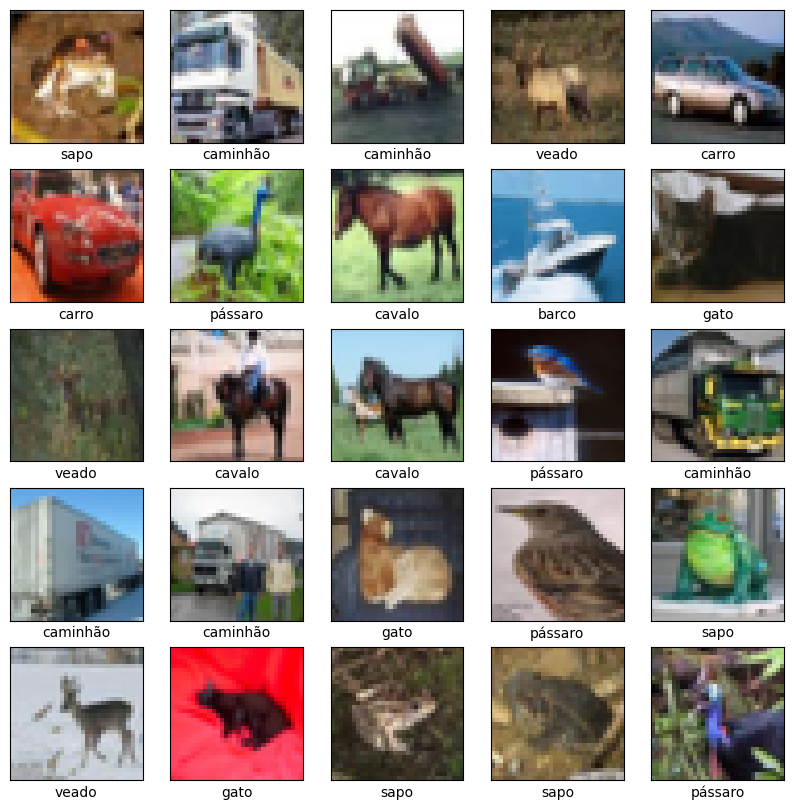

In [7]:
# Mostrando alguns dados do dataset
plt.figure(figsize=[10,10])
for i in range (25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[train_labels[i][0]])

plt.show()

---
É importante verificarmos se será necessário fazer uma normalização.

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]], dtype=uint8)
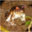

In [8]:
train_images[0]

---
Vimos que as imagens aqui também possuem entradas inteiras entre 0 e 255. Portanto, vamos fazer a mesma normalização que fizemos com os dados do MNIST. Vamos dividir as imagens de treino e teste por 255.

Além disso, vamos identificar cada rótulo numérico à um vetor canônico do $\mathbb{R}^{10}$, em que cada vetor representa uma classe diferente.

In [9]:
# Normalizando as imagens
train_images = train_images / 255
test_images = test_images / 255

# Codificação one-hot das etiquetas
num_classes = 10
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

---
## Experimento 1: Sem Regularização
Finalmente, podemos criar o modelo.

* Usamos também o método `Sequential()` para criarmos uma rede convolucional.
* As camadas convolucionais são chamadas com o método `Conv2D()`. Este método requer vários parâmetros, como quantidade de filtros, tamanho do núcleo do filtro, tipo de preenchimento (padding), tipo de função de ativação, dentre outros. Identificando aqui a camada de entrada temos: `layersConv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3))`, isto é, são 32 filtros que agirão na camada de entrada de dimensão $3\times 3$, o preenchimento deve manter o tamanho original da imagem e a função de ativação associada é a `ReLU`.
* Depois de duas camadas convolucionais fazemos uma camada não-treinável de *pooling* com o método `MaxPooling2D()`, o `pool_size=(dim1,dim2)` corresponde ao tamanho da redução. No nosso caso estamos reduzindo cada uma das dimensões da imagem original por 2.
* Observe que estamos repetindo a estrutura desse bloco mais duas vezes dobrando a quantidade de filtros em cada um deles.
* No quarto e último bloco vem inicialmente uma camada densa com 128 neurônios e em seguida uma camada de 10 neurônios para a saída, com ativação `softmax`.

In [10]:
# Criando um modelo sequência e adicionando camadas nele
KERNEL_SIZE = (3, 3)
INPUT_SHAPE = (32, 32, 3)

model = models.Sequential([
    # Bloco 1: Extrai detalhes como bordas, transição de cores e padrões mais simples
    layers.Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same', name='conv1_1'),
    layers.MaxPool2D(pool_size=(2, 2)),

    # Bloco 2: Extrai detalhes dados pela combinação dos filtros anteriores
    layers.Conv2D(filters=64, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv2_1'),
    layers.MaxPool2D(pool_size=(2, 2)),

    # Bloco 3: Extrai detalhes mais abstratos
    layers.Conv2D(filters=128, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv3_1'),
    layers.MaxPool2D(pool_size=(2, 2)),

    # Classificador
    layers.Flatten(), # o flatten é necessário pois o banco de filtros é retangular
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


*Obs.: o vídeo [https://www.youtube.com/watch?v=UZDiGooFs54](https://www.youtube.com/watch?v=UZDiGooFs54) traz uma visualização muito interessante em tempo real do que o banco de filtros captura.*

---

---
Vamos agora mostrar o resumo do modelo.

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

---
Compilando o modelo.

Vamos de: ADAM, cross-entropy e a métrica é a acurácia.

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

---
Para treinar o modelo vamos fazer um treinamento com 12 épocas e em lotes de 64 imagens.

*Obs:* na descida de gradiente em lote você processa todo o conjunto de treinamento em uma iteração. Enquanto que em uma descida de gradiente em minilotes você processa um pequeno subconjunto do conjunto de treinamento em cada iteração. Neste caso, em lotes de tamanho 64.

In [13]:
history = model.fit(train_images, train_labels, batch_size=64, epochs=15,
                    validation_data=(test_images, test_labels))

Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.3756 - loss: 1.7087 - val_accuracy: 0.5867 - val_loss: 1.1631
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6158 - loss: 1.0923 - val_accuracy: 0.6425 - val_loss: 1.0267
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6965 - loss: 0.8720 - val_accuracy: 0.6993 - val_loss: 0.8639
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7389 - loss: 0.7520 - val_accuracy: 0.7192 - val_loss: 0.8216
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7721 - loss: 0.6609 - val_accuracy: 0.7304 - val_loss: 0.7881
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7959 - loss: 0.5865 - val_accuracy: 0.7295 - val_loss: 0.8186
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8255 - loss: 0.4982 - val_accuracy: 0.7433 - val_loss: 0.7747
Epoch 8/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8466 - loss: 0.4399 - val_acc

Visualizando e avaliando os resultados

In [14]:
# Avaliar o modelo no conjunto de teste
loss, accuracy = model.evaluate(test_images, test_labels, verbose=0)

print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

Acurácia no conjunto de teste: 0.7435


Text(0.5, 1.0, 'Curvas de perda')

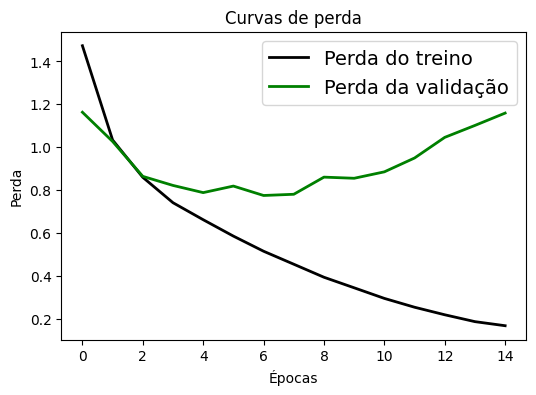

In [15]:
# Curva de perda
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Perda do treino', 'Perda da validação'], fontsize=14)
plt.xlabel('Épocas', fontsize=10)
plt.ylabel('Perda', fontsize=10)
plt.title('Curvas de perda', fontsize=12)

Text(0.5, 1.0, 'Curva de acurácia')

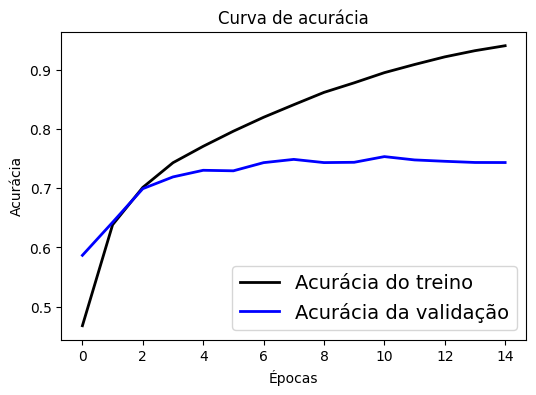

In [16]:
# Curva de acurácia
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Acurácia do treino', 'Acurácia da validação'], fontsize=14)
plt.xlabel('Épocas', fontsize=10)
plt.ylabel('Acurácia', fontsize=10)
plt.title('Curva de acurácia', fontsize=12)

---
Agora é a hora de ver se o modelo treinou direitinho

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


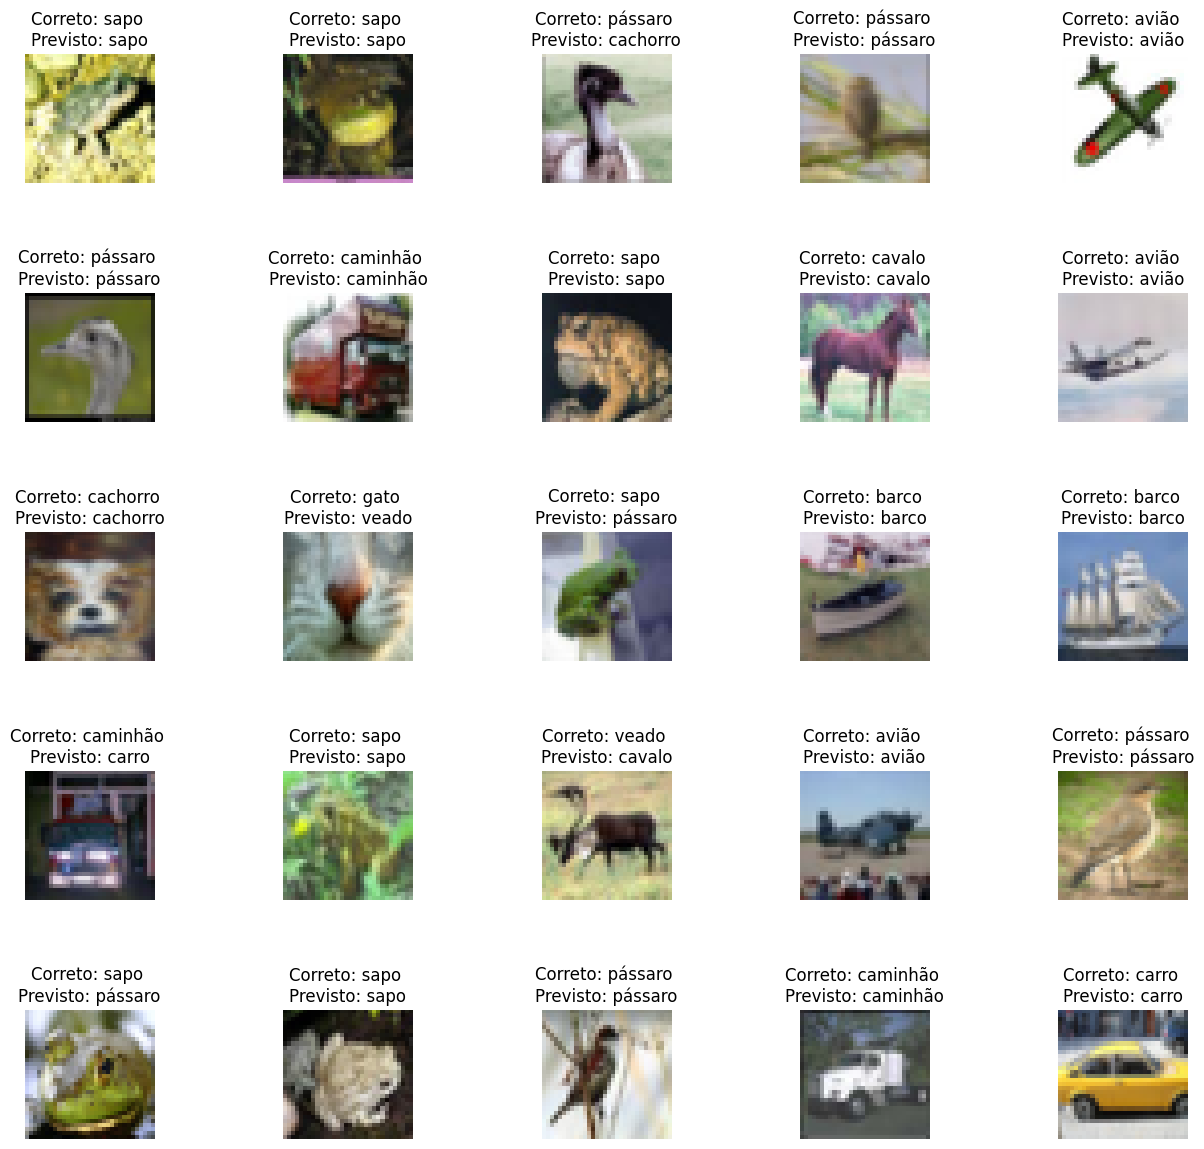

In [17]:
# Mostrando o verdadeiro vs. Resultado previsto

# Fazendo as previsões
pred = model.predict(test_images)

# Convertendo as previsões nos índices das etiquetas
pred_classes = np.argmax(pred, axis=1)

fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()

for i in np.arange(0, 25):
    random_num = np.random.choice(len(test_images))
    axes[i].imshow(test_images[random_num])
    axes[i].set_title("Correto: %s \nPrevisto: %s" % (class_names[np.argmax(test_labels[random_num])], class_names[pred_classes[random_num]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

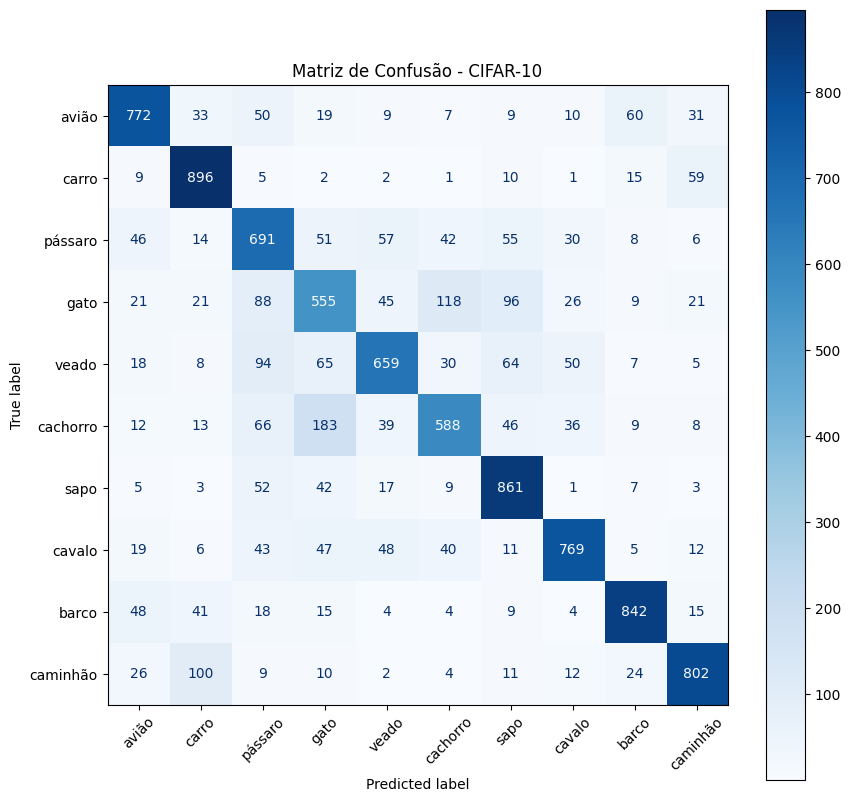

In [18]:
# Gera a matriz de confusão

# Calcular e exibir a matriz de confusão
cm_cifar = confusion_matrix(np.argmax(test_labels, axis=1), pred_classes)
disp_cifar = ConfusionMatrixDisplay(confusion_matrix=cm_cifar, display_labels=class_names)

# Usamos um tamanho de figura maior e rotação nos rótulos para melhor visualização
fig, ax = plt.subplots(figsize=(10, 10))
disp_cifar.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - CIFAR-10")
plt.xticks(rotation=45)
plt.show()


---
## Visualização das camadas convolucionais

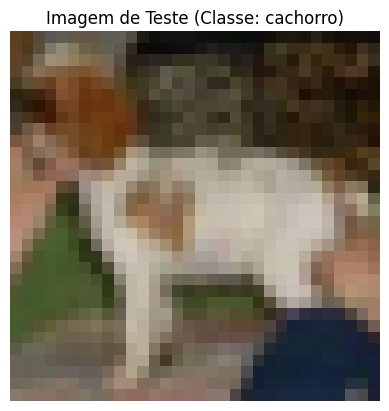

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Número de mapas de ativação retornadas: 3
Forma do primeiro mapa de ativação: (1, 32, 32, 32)


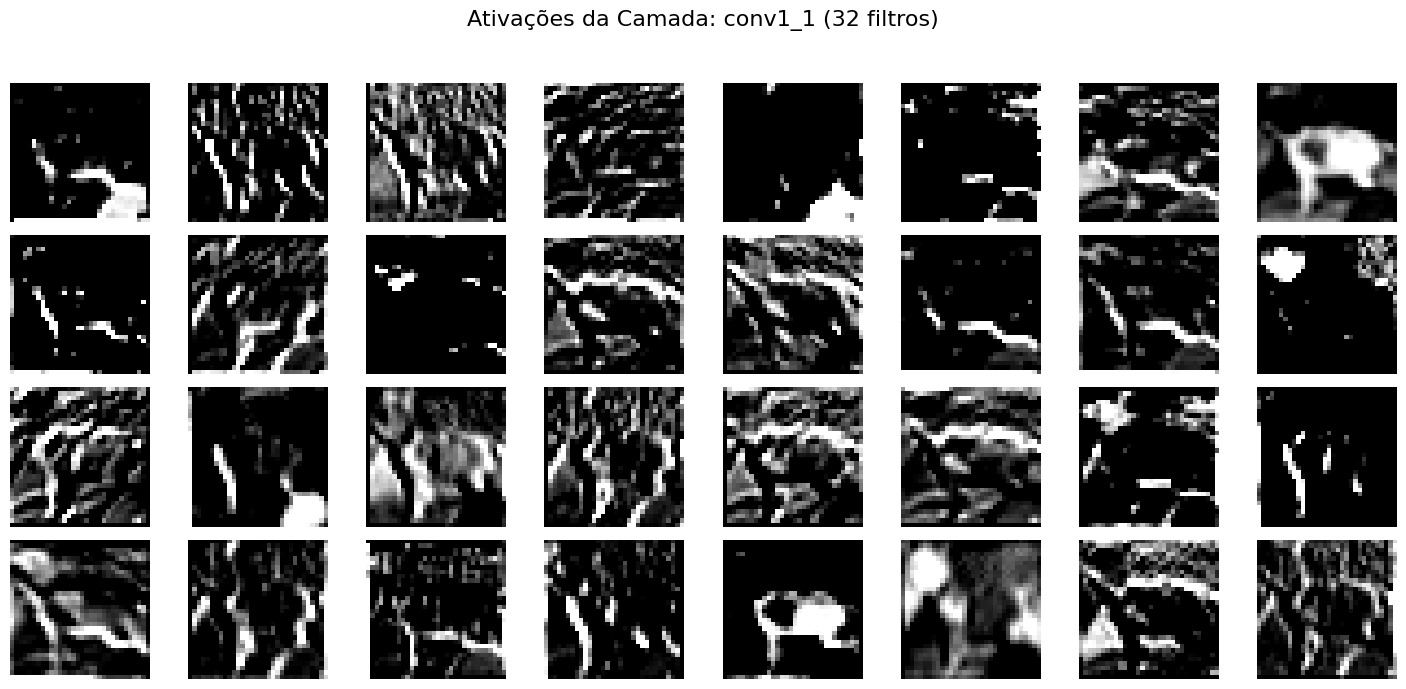

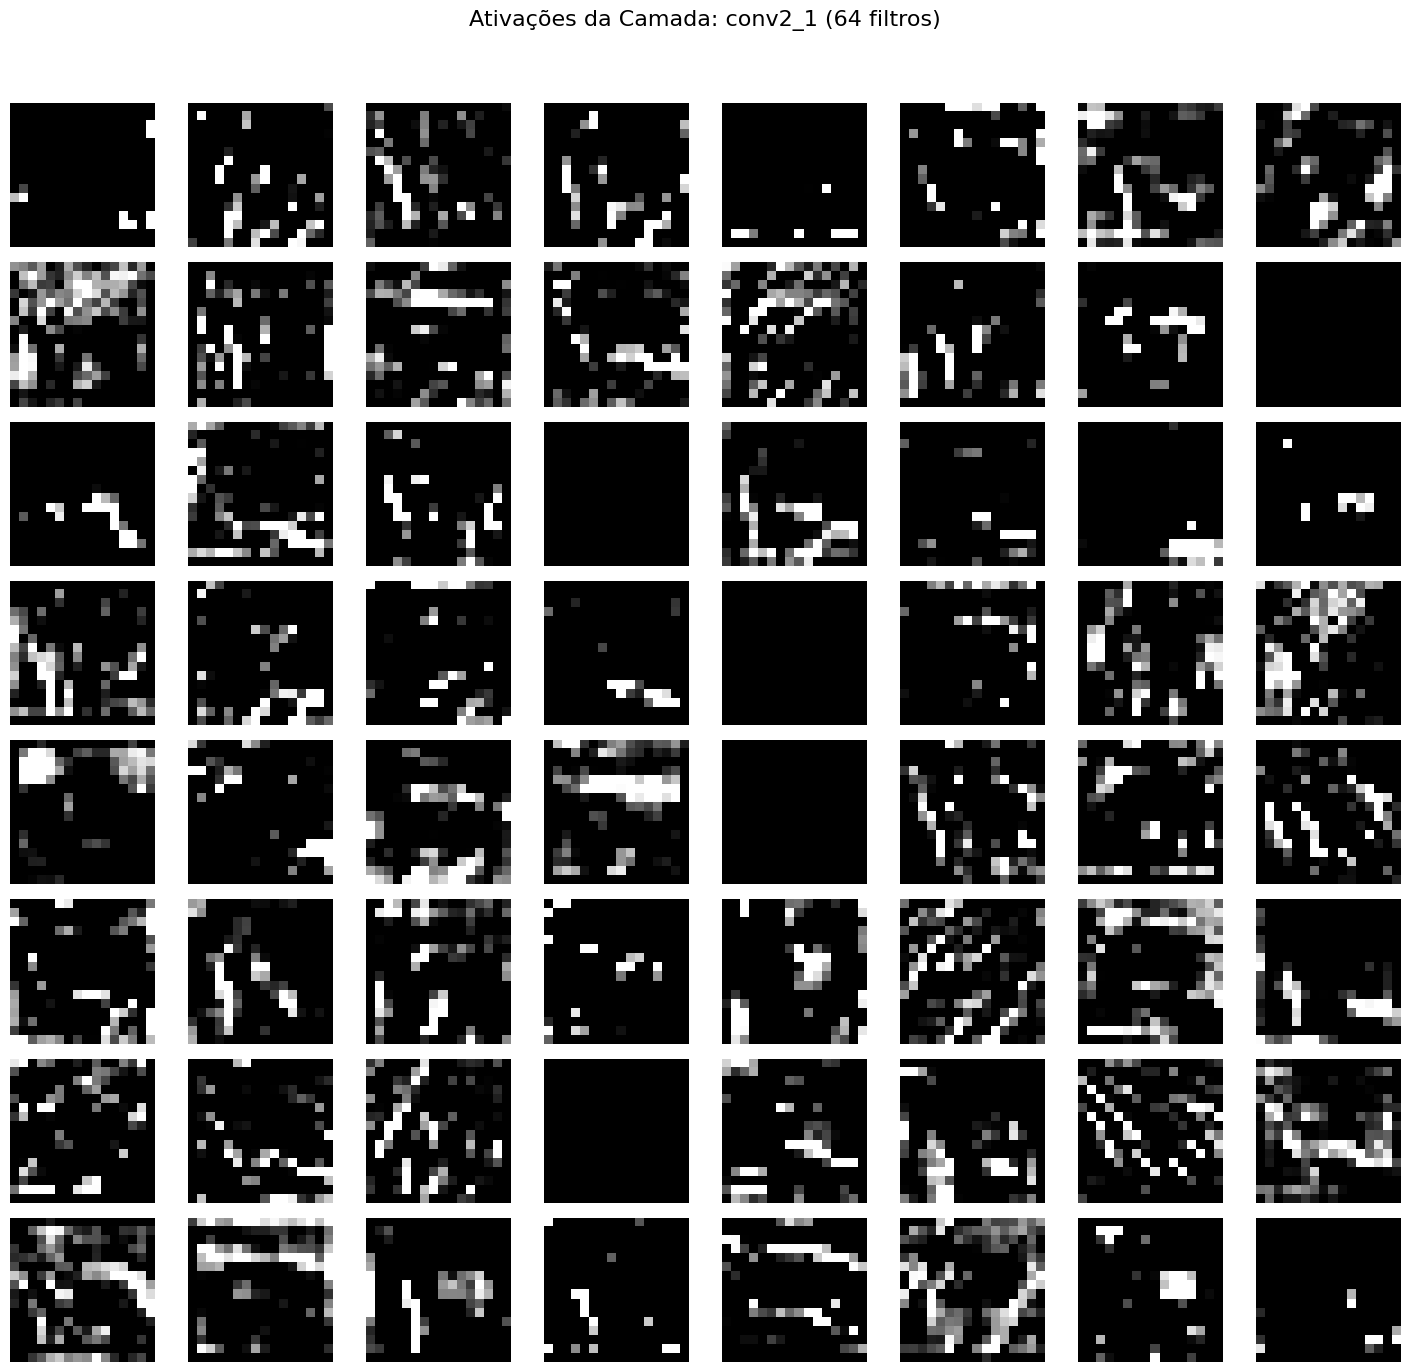

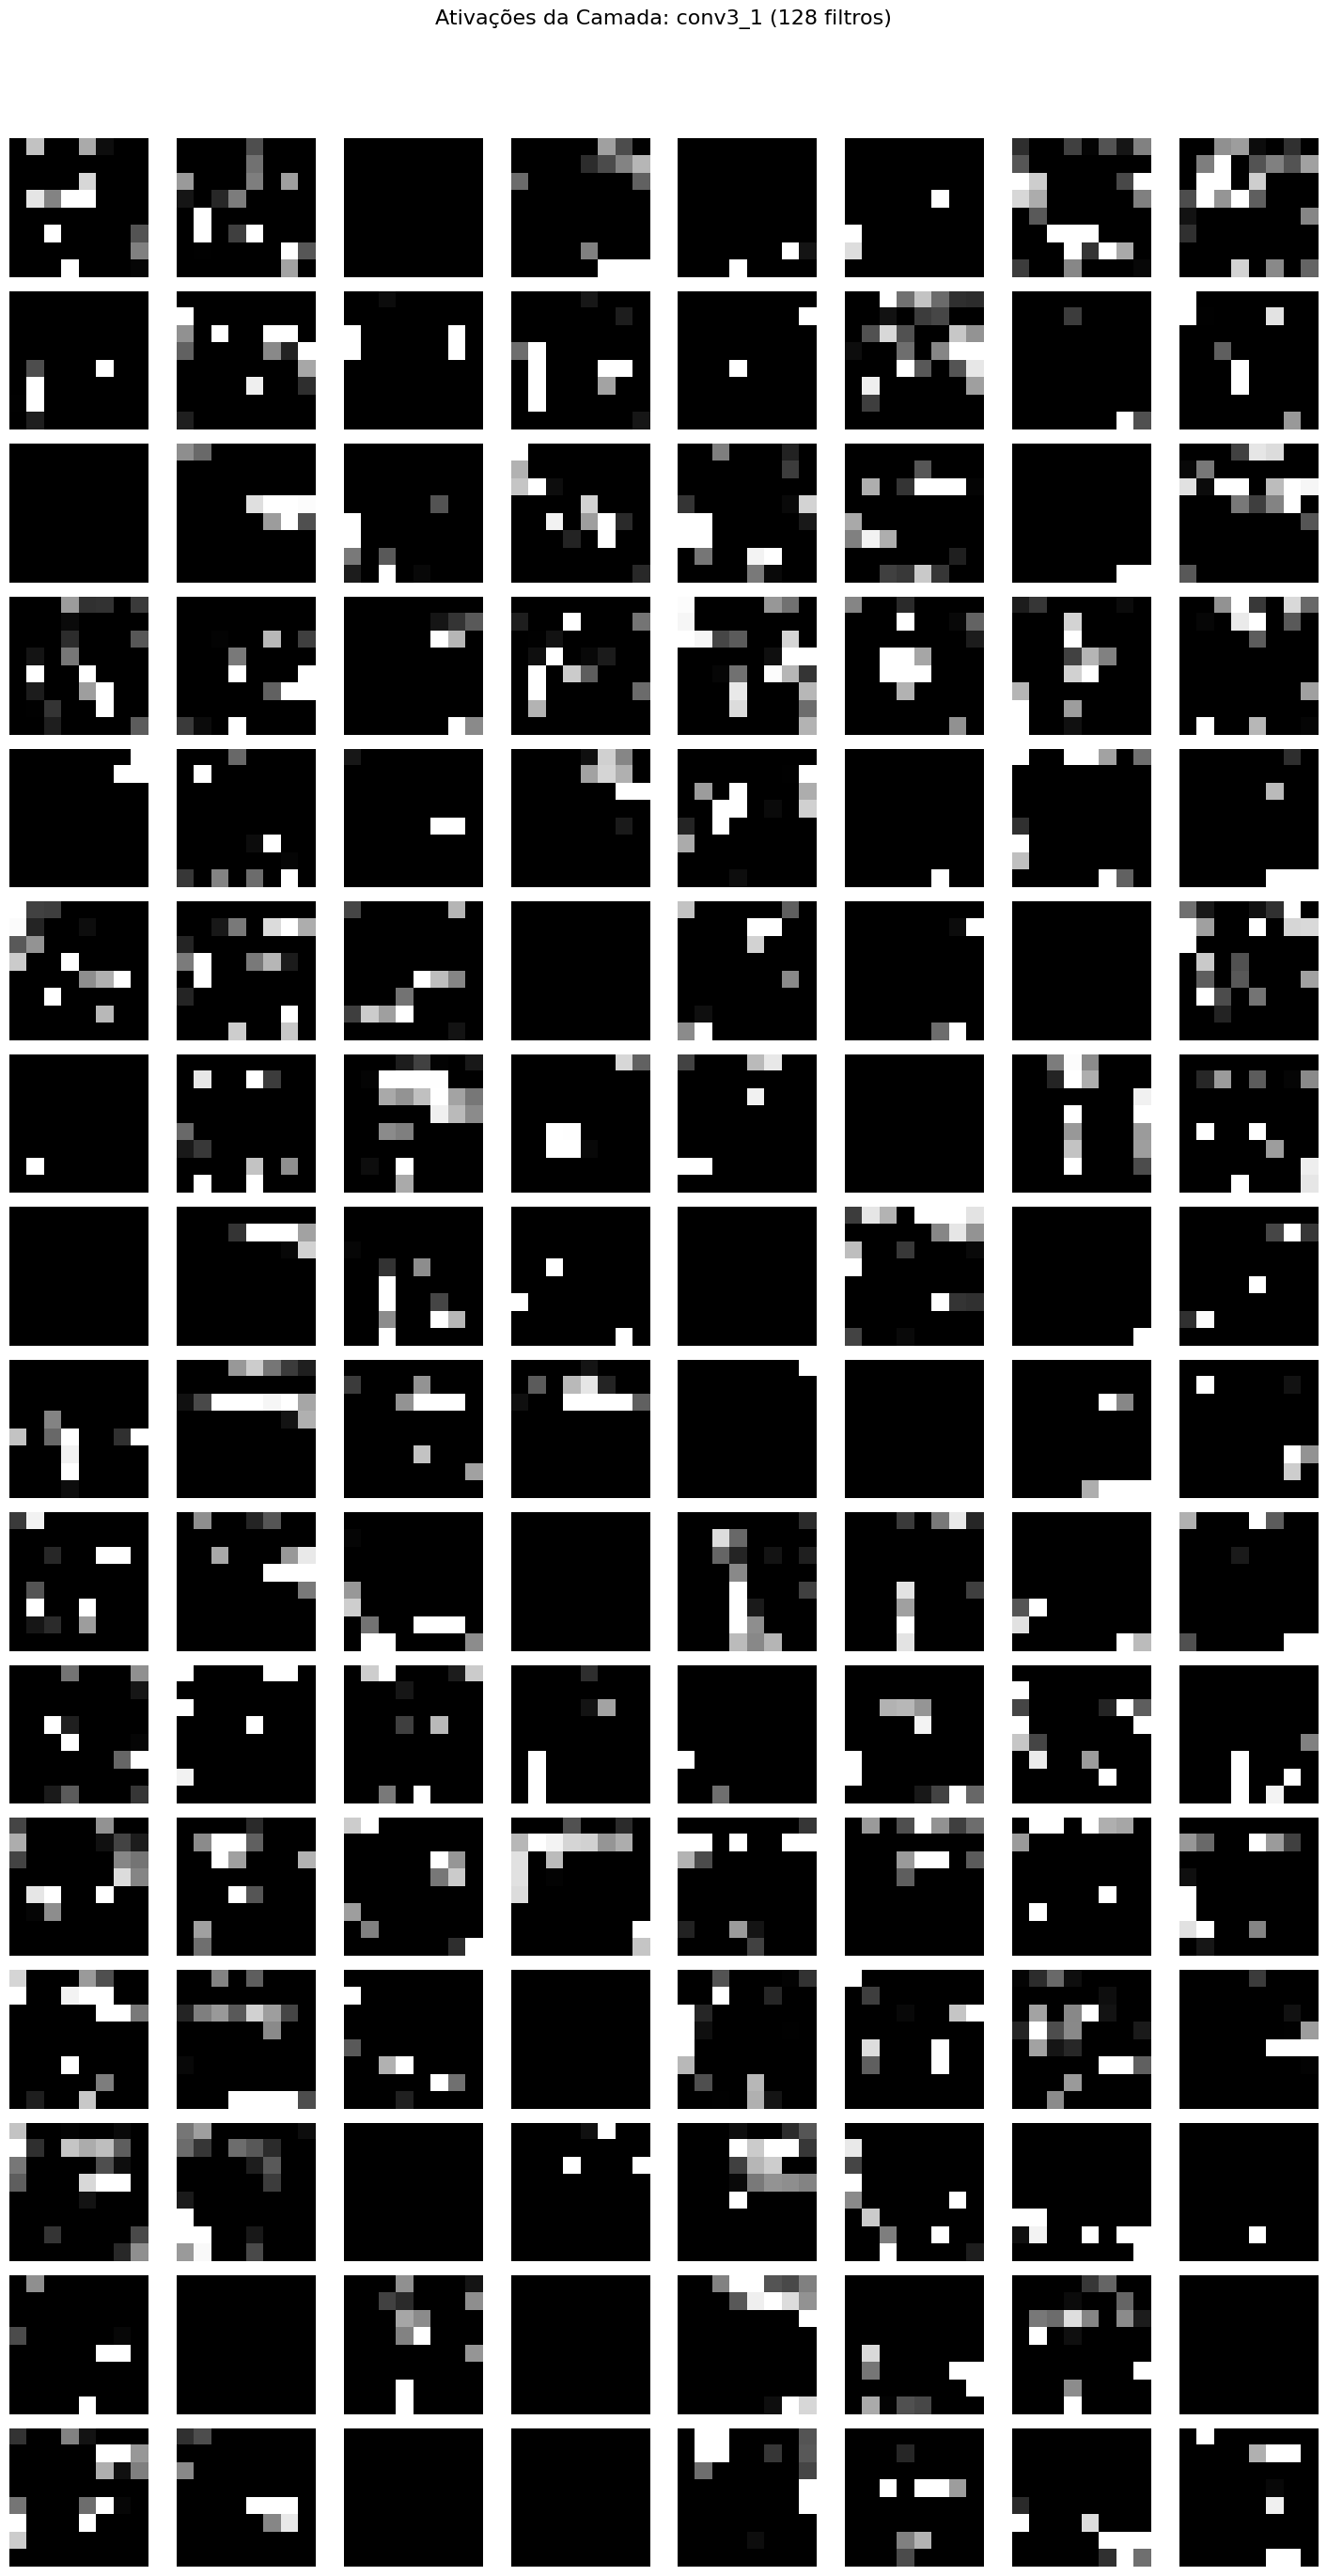

In [19]:
# Nomes das camadas convolucionais que queremos visualizar
layer_names = ['conv1_1', 'conv2_1', 'conv3_1']

# Cria o modelo que retorna essas saídas, dado a entrada do modelo original
input_tensor = keras.Input(shape=INPUT_SHAPE)
x = input_tensor

outputs = []
# Iterar pelas camadas do modelo original
for layer in model.layers:
    # Passe o tensor atual 'x' pela camada
    x = layer(x)
    # Se a camada atual for uma das camadas de destino, adicione sua saída à lista de saídas
    if layer.name in layer_names:
        outputs.append(x)

activation_model = models.Model(inputs=input_tensor, outputs=outputs)

# Escolha uma imagem do conjunto de teste para visualizar
img_tensor = test_images[12:13]  # Pegando a 12ª imagem. Mantemos a dimensão do lote (1, 32, 32, 3)
true_label = class_names[np.argmax(test_labels[12])]

# Exibir a imagem original
plt.imshow(img_tensor[0])
plt.title(f"Imagem de Teste (Classe: {true_label})")
plt.axis('off')
plt.show()

# Obter as ativações
activations = activation_model.predict(img_tensor)

print(f"Número de mapas de ativação retornadas: {len(activations)}")
# Exemplo da forma da primeira camada de ativação (1 imagem, altura, largura, 32 filtros)
print(f"Forma do primeiro mapa de ativação: {activations[0].shape}")

def plot_activations(activations, layer_names, images_per_row=8):
    """Plota os mapas de ativação de forma organizada."""
    # O zip agora combina os nomes e as ativações corretamente
    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1]
        n_cols = min(n_features, images_per_row)
        n_rows = (n_features + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.8, n_rows * 1.8))
        fig.suptitle(f"Ativações da Camada: {layer_name} ({n_features} filtros)", fontsize=16)

        if n_rows == 1 and n_cols == 1: axes = np.array([[axes]])
        elif n_rows == 1 or n_cols == 1: axes = np.expand_dims(axes, axis=0 if n_cols > 1 else 1)

        for i in range(n_rows * n_cols):
            row, col = i // n_cols, i % n_cols
            ax = axes[row, col]
            if i < n_features:
                channel = layer_activation[0, :, :, i]
                if channel.std() > 1e-6:
                    channel = (channel - channel.mean()) / channel.std() * 64 + 128
                else:
                    channel = channel - channel.mean() + 128
                channel = np.clip(channel, 0, 255).astype('uint8')
                ax.imshow(channel, cmap='grey')
            ax.axis('off')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Chamar a função para plotar tudo
plot_activations(activations, layer_names, images_per_row=8)


Baixando imagem de: https://petcare.com.br/wp-content/uploads/2013/01/sphynx-3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


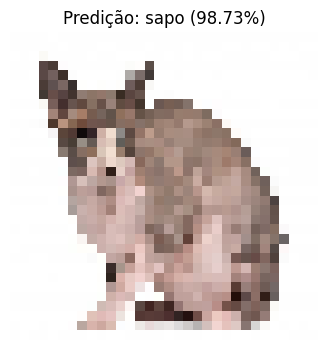


--- Exibindo Mapas de Ativação para a Imagem Externa ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


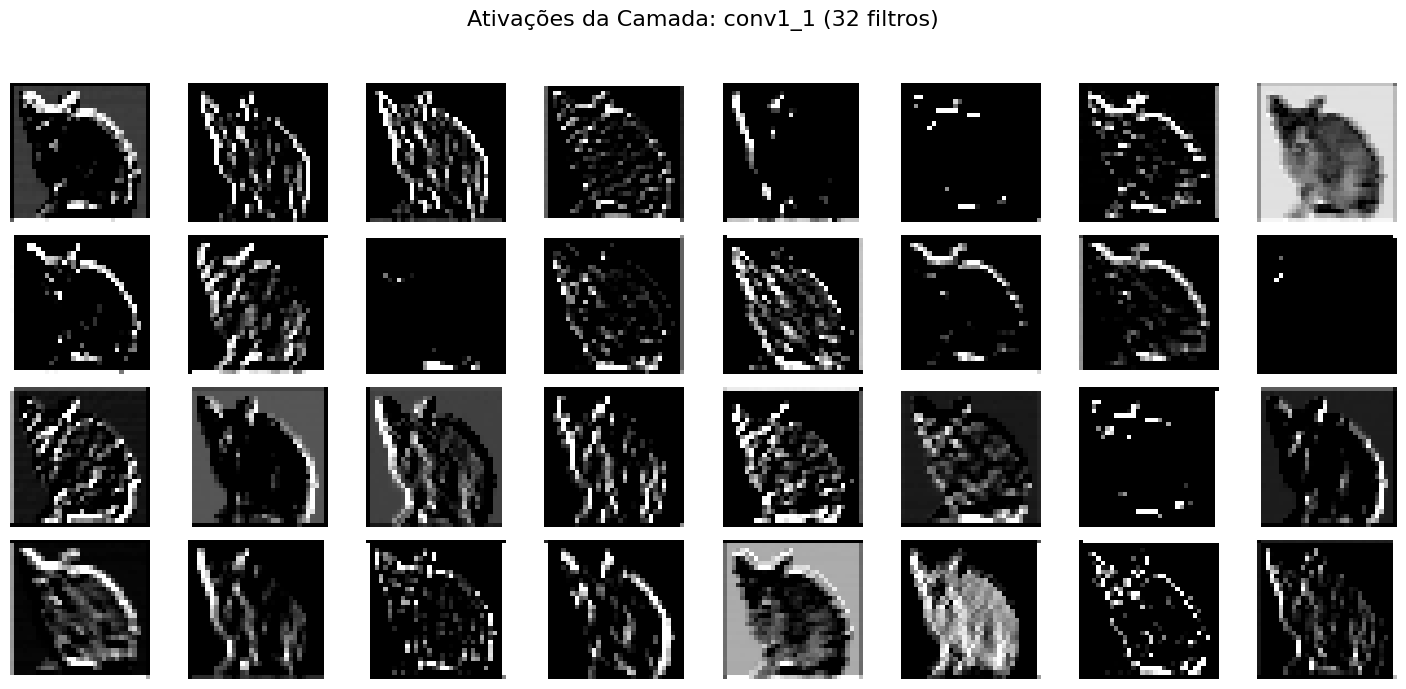

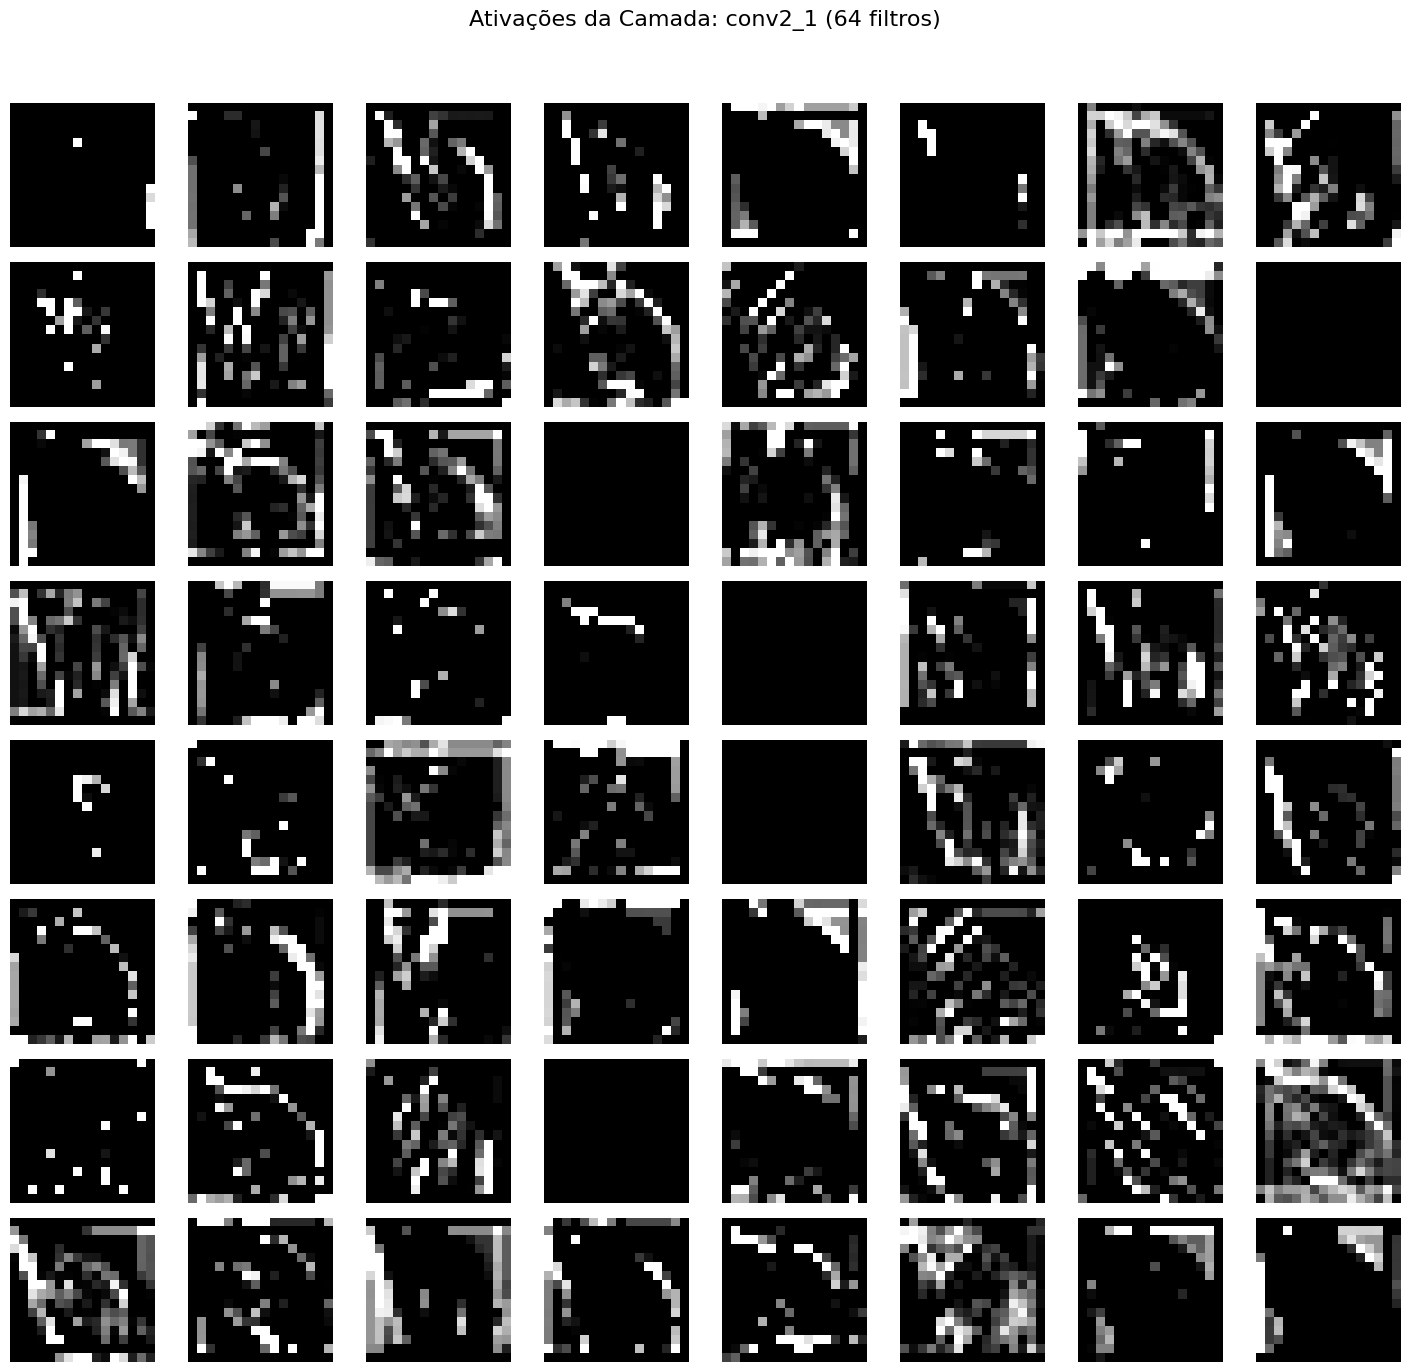

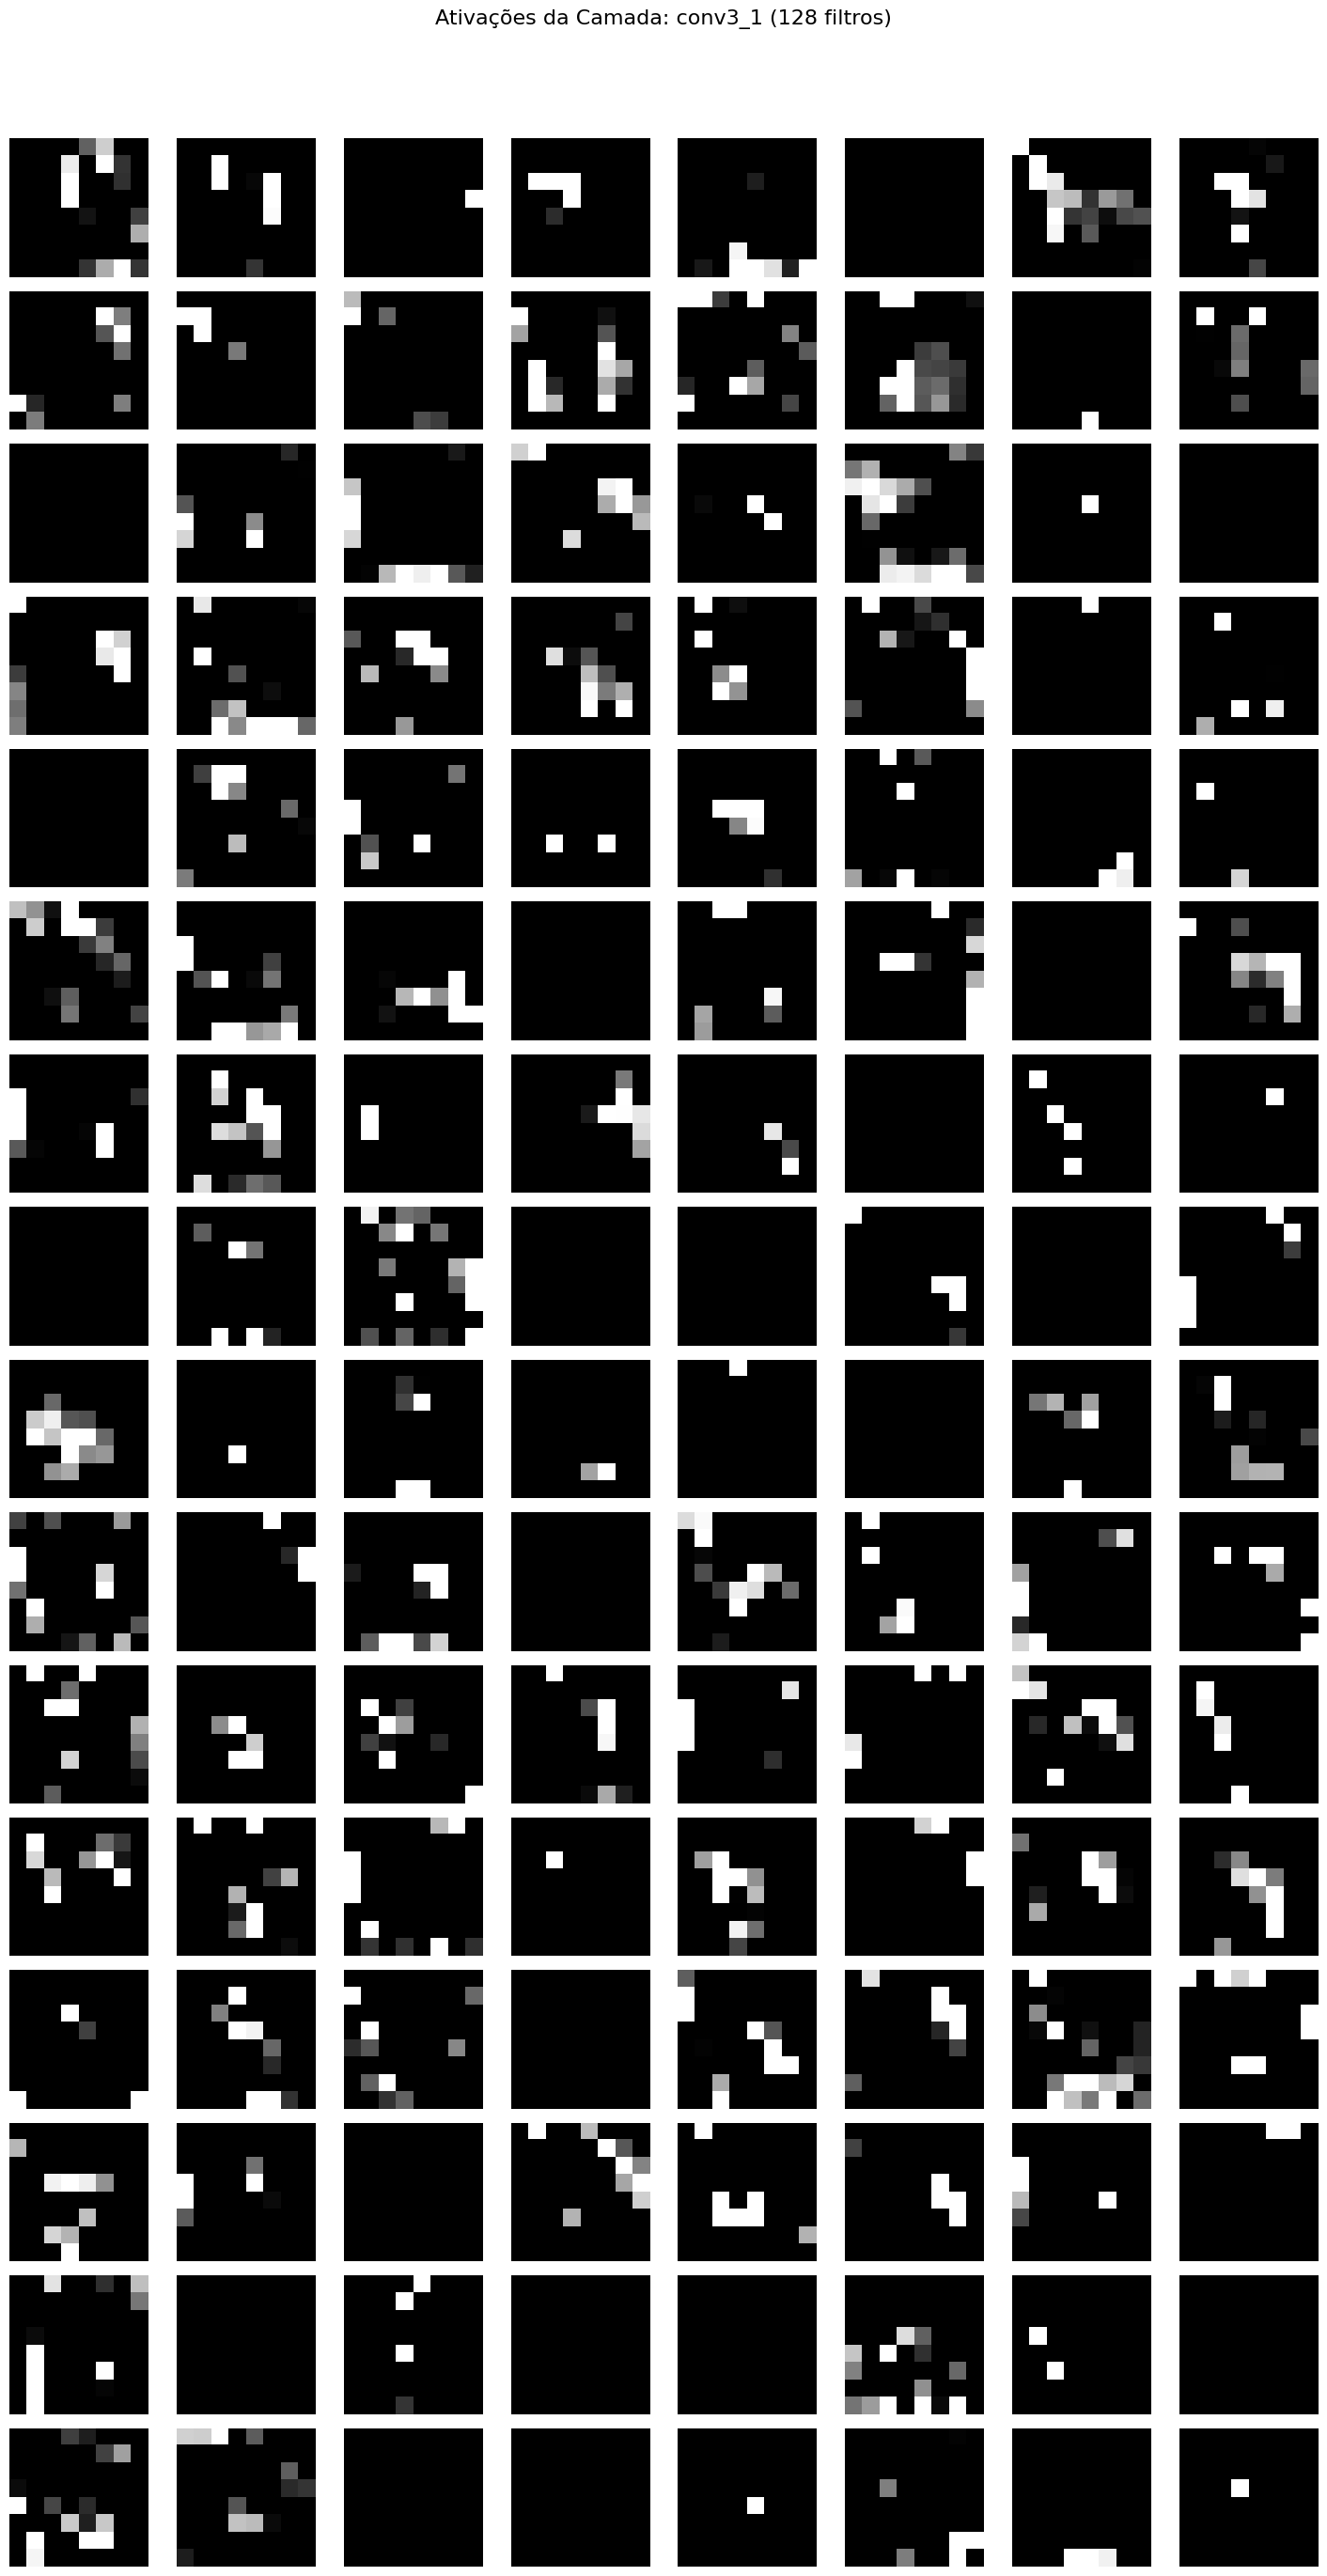

In [20]:
from keras.utils import load_img, img_to_array
import urllib.request

def preprocess_external_image(img_path, target_size=(32, 32)):
    """Carrega uma imagem e a prepara para o modelo."""
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_tensor = np.expand_dims(img_array, axis=0)
    return img_tensor, img

# URL de uma imagem para teste.
IMAGE_URL = "https://petcare.com.br/wp-content/uploads/2013/01/sphynx-3.jpg" # Imagem de um gato
IMAGE_PATH = "imagem_externa.jpg"

print(f"\nBaixando imagem de: {IMAGE_URL}")
urllib.request.urlretrieve(IMAGE_URL, IMAGE_PATH)

# Pré-processa a imagem e realiza a predição
img_tensor, original_img = preprocess_external_image(IMAGE_PATH)
predictions = model.predict(img_tensor)
predicted_index = np.argmax(predictions[0])
predicted_class = class_names[predicted_index]
confidence = np.max(predictions[0]) * 100

# Mostra a imagem com o resultado
plt.figure(figsize=(4, 4))
plt.imshow(original_img)
plt.title(f"Predição: {predicted_class} ({confidence:.2f}%)")
plt.axis('off')
plt.show()

# Mostra os mapas de ativação
print("\n--- Exibindo Mapas de Ativação para a Imagem Externa ---")
activations = activation_model.predict(img_tensor)
plot_activations(activations, layer_names)

---
## Experimento 2: Batch Normalization

Aqui vamos começar a introduzir as regularizações e verificar quais efeitos produzem. Iniciamos com o Batch Normalization.

## O que é Batch Normalization (Normalização em Lote)?

**Batch Normalization** é uma técnica de treinamento cuja ideia principal é normalizar a entrada de cada camada para que ela tenha uma média de 0 e um desvio padrão de 1.

No entanto, em vez de normalizar a saída de uma camada usando as estatísticas de todo o conjunto de dados (o que seria computacionalmente caro), a normalização em lote faz isso utilizando apenas as estatísticas (média e variância) do **mini-lote (mini-batch)** de dados que está passando pela rede naquele momento.

### Qual o seu objetivo principal?

O principal objetivo da Batch Normalization é combater o problema chamado **"Internal Covariate Shift"**.

*   **O que é isso?** Durante o treinamento, os pesos de cada camada são atualizados. Isso faz com que a distribuição dos dados de saída dessa camada (que são a entrada para a próxima camada) mude constantemente.
*   **Por que é um problema?** A camada seguinte precisa se readaptar constantemente a essa distribuição em mudança, o que torna o processo de aprendizado mais lento e instável. É como tentar acertar um alvo em movimento.

Ao normalizar a entrada de cada camada, a BN garante que a distribuição desses dados permaneça mais estável (média 0, variância 1) ao longo do treinamento, facilitando o trabalho da camada seguinte e estabilizando todo o processo de aprendizado.

### Quais são os seus efeitos e benefícios?

A inclusão da Batch Normalization em um modelo traz vários benefícios significativos:

1.  **Acelera o Treinamento:** Como o aprendizado é mais estável, podemos usar taxas de aprendizado (learning rates) mais altas, o que acelera drasticamente a convergência do modelo.
2.  **Reduz a Dependência da Inicialização de Pesos:** O modelo se torna menos sensível à escolha dos pesos iniciais, pois a normalização ajuda a manter as ativações em uma escala razoável desde o início.
3.  **Atua como um Regularizador:** A "imperfeição" de calcular a média e a variância apenas no mini-lote introduz um leve ruído no processo. Esse ruído tem um efeito de regularização, semelhante ao *Dropout*, ajudando a prevenir o *overfitting*. Em alguns casos, pode até substituir a necessidade de *Dropout* que veremos a seguir.
4.  **Permite Redes Mais Profundas:** Ajuda a mitigar os problemas de gradientes que desaparecem ou explodem (vanishing/exploding gradients), tornando viável o treinamento de redes neurais muito mais profundas.

### Como e Onde incluir no Modelo?

A prática mais comum e eficaz é inserir a camada de Batch Normalization **depois da camada principal (Convolucional ou Densa) e ANTES da função de ativação não-linear**.

**Ordem recomendada:** `CONV/DENSE -> BATCH NORM -> ACTIVATION`


In [21]:
# Criando um modelo sequência e adicionando camadas nele
KERNEL_SIZE = (3, 3)
INPUT_SHAPE = (32, 32, 3)

model = models.Sequential([
    # Bloco 1
    layers.Conv2D(filters=16, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same', name='conv1_1'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=16, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv1_2'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),

    # Bloco 2
    layers.Conv2D(filters=32, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv2_1'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=32, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv2_2'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),

    # Bloco 3
    layers.Conv2D(filters=64, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv3_1'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv3_2'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),

    # Classificador
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=15,
                    validation_data=(test_images, test_labels))

Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.4563 - loss: 1.5526 - val_accuracy: 0.6399 - val_loss: 1.0454
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.6948 - loss: 0.8784 - val_accuracy: 0.6406 - val_loss: 1.0304
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.7529 - loss: 0.7102 - val_accuracy: 0.7244 - val_loss: 0.8170
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.7905 - loss: 0.5925 - val_accuracy: 0.7322 - val_loss: 0.7975
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8262 - loss: 0.4969 - val_accuracy: 0.7529 - val_loss: 0.7392
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8550 - loss: 0.4248 - val_accuracy: 0.7652 - val_loss: 0.7443
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8745 - loss: 0.3685 - val_accuracy: 0.7325 - val_loss: 0.8974
Epoch 8/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8918 - loss: 0.3132 - 

In [23]:
# Avaliar o modelo no conjunto de teste
loss, accuracy = model.evaluate(test_images, test_labels, verbose=0)

print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

Acurácia no conjunto de teste: 0.7676


Text(0.5, 1.0, 'Curva de acurácia')

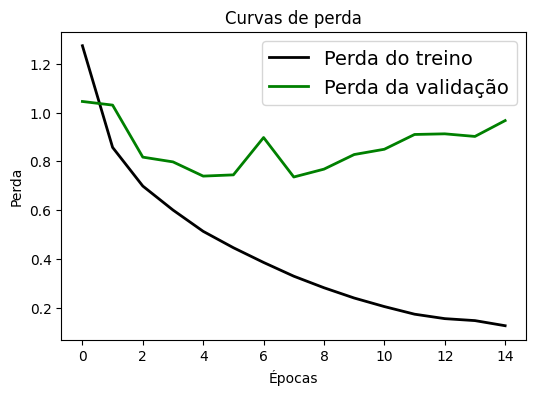

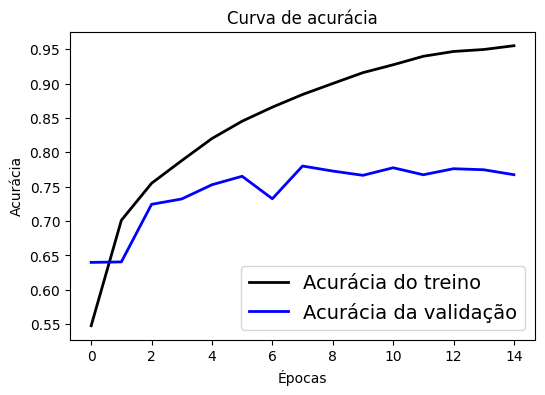

In [24]:
# Curva de perda
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Perda do treino', 'Perda da validação'], fontsize=14)
plt.xlabel('Épocas', fontsize=10)
plt.ylabel('Perda', fontsize=10)
plt.title('Curvas de perda', fontsize=12)

# Curva de acurácia
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Acurácia do treino', 'Acurácia da validação'], fontsize=14)
plt.xlabel('Épocas', fontsize=10)
plt.ylabel('Acurácia', fontsize=10)
plt.title('Curva de acurácia', fontsize=12)

---
## Experimento 3: Dropout


## O que é Dropout?

**Dropout** é uma das técnicas de **regularização** mais populares e eficazes para redes neurais. A ideia é surpreendentemente simples: durante o treinamento, em cada passo ou iteração, a camada de Dropout "desliga" (isto é, zera a saída de) aleatoriamente uma fração dos neurônios da camada anterior.

Imagine que você tem um time de especialistas trabalhando para resolver um problema. Se, a cada dia, alguns especialistas aleatoriamente faltam ao trabalho, os especialistas restantes não podem depender de ninguém em particular. Cada um precisa se tornar mais competente e robusto em suas próprias conclusões. O Dropout faz exatamente isso com os neurônios.

A fração de neurônios a ser "desligada" é definida por um hiperparâmetro chamado **taxa de dropout (rate)**, geralmente um valor entre 0.2 e 0.5. Uma taxa de `0.5` significa que, em média, 50% dos neurônios daquela camada serão desativados em cada passo do treinamento.

**Importante:** O Dropout só é aplicado durante o **treinamento**. Durante a fase de **inferência (previsão)**, todos os neurônios são utilizados, mas suas saídas são escalonadas por um fator igual à taxa de dropout para compensar o fato de que mais neurônios estão ativos do que no treinamento. Felizmente, o Keras e o PyTorch fazem isso automaticamente para nós.

### Qual o seu objetivo principal?

O objetivo central do Dropout é **prevenir o overfitting**.

*   **O que é overfitting?** É quando um modelo aprende os dados de treinamento "bem demais", incluindo o ruído e as particularidades do conjunto de treino. Como resultado, ele perde a capacidade de generalizar para dados novos e nunca vistos.
*   **Como o Dropout ajuda?** Ao forçar os neurônios a trabalharem em configurações aleatórias, o Dropout impede que eles desenvolvam uma **"co-adaptação" complexa**. Isso acontece quando um neurônio aprende a corrigir os erros de outro neurônio específico, criando uma dependência frágil que não funciona bem com novos dados. Com o Dropout, cada neurônio é forçado a aprender características que são úteis por si só, tornando o modelo final mais robusto e generalizável.

### Quais são os seus efeitos e benefícios?

1.  **Redução do Overfitting:** Este é o benefício principal e mais direto. Modelos com Dropout geralmente apresentam uma diferença menor entre a acurácia de treino e a de validação.
2.  **Criação de Modelos Mais Robustos:** O modelo não depende excessivamente de nenhum neurônio ou característica específica, aprendendo representações mais distribuídas e resilientes.
3.  **Simula um "Ensemble" de Modelos:** De certa forma, cada passo de treinamento com Dropout treina uma rede neural "reduzida" diferente. O resultado final se comporta como uma média (ou "ensemble") de milhares de redes neurais diferentes, o que é uma técnica poderosa para melhorar o desempenho.

### Como e Onde incluir no Modelo?

A camada de Dropout é mais comumente aplicada nas **camadas densas (totalmente conectadas)** do modelo, especialmente nas que têm um grande número de neurônios, pois são mais propensas ao *overfitting*.

A prática padrão é inserir a camada de Dropout após a função de ativação.

**Ordem recomendada:** `DENSE -> ACTIVATION -> DROPOUT`

Se você estiver usando com Batch Normalization, a ordem mais comum é:
`DENSE -> BATCH NORM -> ACTIVATION -> DROPOUT`



In [25]:
# Criando um modelo sequência e adicionando camadas nele

KERNEL_SIZE = (3, 3)
INPUT_SHAPE = (32, 32, 3)

model = models.Sequential([
    # Bloco 1
    layers.Conv2D(filters=16, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same', name='conv1_1'),
    layers.Conv2D(filters=16, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv1_2'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Bloco 2
    layers.Conv2D(filters=32, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv2_1'),
    layers.Conv2D(filters=32, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv2_2'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Bloco 3
    layers.Conv2D(filters=64, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv3_1'),
    layers.Conv2D(filters=64, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv3_2'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Classificador
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(10, activation='softmax')
])

In [26]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=25,
                    validation_data=(test_images, test_labels))

Epoch 1/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.2623 - loss: 1.9498 - val_accuracy: 0.5176 - val_loss: 1.3259
Epoch 2/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.4964 - loss: 1.3769 - val_accuracy: 0.6084 - val_loss: 1.0996
Epoch 3/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5744 - loss: 1.1855 - val_accuracy: 0.6277 - val_loss: 1.0299
Epoch 4/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6167 - loss: 1.0772 - val_accuracy: 0.6750 - val_loss: 0.9349
Epoch 5/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6469 - loss: 0.9910 - val_accuracy: 0.6842 - val_loss: 0.8846
Epoch 6/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6714 - loss: 0.9329 - val_accuracy: 0.6876 - val_loss: 0.8928
Epoch 7/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6868 - loss: 0.8821 - val_accuracy: 0.7174 - val_loss: 0.7961
Epoch 8/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7021 - loss: 0.8472 - 

In [27]:
# Avaliar o modelo no conjunto de teste
loss, accuracy = model.evaluate(test_images, test_labels, verbose=0)

print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

Acurácia no conjunto de teste: 0.7760


Text(0.5, 1.0, 'Curva de acurácia')

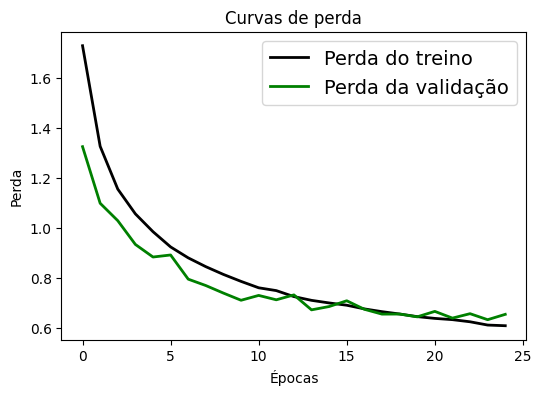

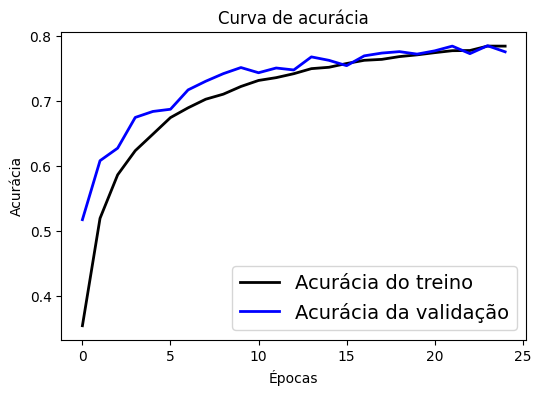

In [28]:
# Curva de perda
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Perda do treino', 'Perda da validação'], fontsize=14)
plt.xlabel('Épocas', fontsize=10)
plt.ylabel('Perda', fontsize=10)
plt.title('Curvas de perda', fontsize=12)

# Curva de acurácia
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Acurácia do treino', 'Acurácia da validação'], fontsize=14)
plt.xlabel('Épocas', fontsize=10)
plt.ylabel('Acurácia', fontsize=10)
plt.title('Curva de acurácia', fontsize=12)

---

##Experimento 4: Combinando Dropout e Batch Normalization

In [29]:
# Criando um modelo sequência e adicionando camadas nele

KERNEL_SIZE = (3, 3)
INPUT_SHAPE = (32, 32, 3)

model = models.Sequential([
    # Bloco 1
    layers.Conv2D(filters=16, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same', name='conv1_1'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=16, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv1_2'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Bloco 2
    layers.Conv2D(filters=32, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv2_1'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=32, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv2_2'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Bloco 3
    layers.Conv2D(filters=64, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv3_1'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv3_2'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Classificador
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(10, activation='softmax')
])

In [30]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=25,
                    validation_data=(test_images, test_labels))

Epoch 1/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.3638 - loss: 1.8807 - val_accuracy: 0.5909 - val_loss: 1.1366
Epoch 2/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5774 - loss: 1.1945 - val_accuracy: 0.6447 - val_loss: 0.9943
Epoch 3/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6554 - loss: 0.9771 - val_accuracy: 0.7029 - val_loss: 0.8556
Epoch 4/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6949 - loss: 0.8747 - val_accuracy: 0.7189 - val_loss: 0.8159
Epoch 5/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7203 - loss: 0.8008 - val_accuracy: 0.7523 - val_loss: 0.7043
Epoch 6/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7416 - loss: 0.7344 - val_accuracy: 0.7522 - val_loss: 0.7172
Epoch 7/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7563 - loss: 0.6972 - val_accuracy: 0.7337 - val_loss: 0.7683
Epoch 8/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7670 - loss: 0.6677 - 

Text(0.5, 1.0, 'Curva de acurácia')

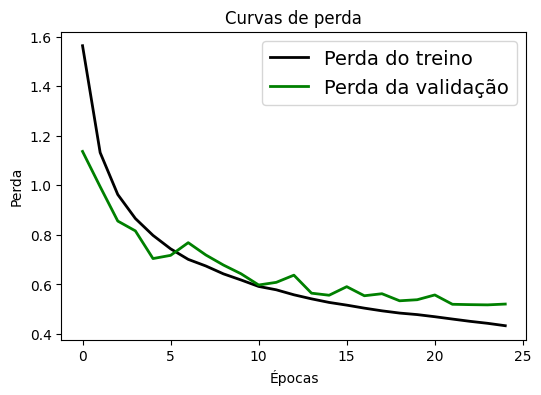

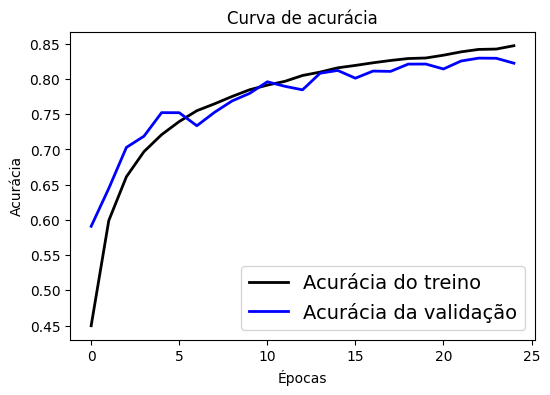

In [31]:
# Curva de perda
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Perda do treino', 'Perda da validação'], fontsize=14)
plt.xlabel('Épocas', fontsize=10)
plt.ylabel('Perda', fontsize=10)
plt.title('Curvas de perda', fontsize=12)

# Curva de acurácia
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Acurácia do treino', 'Acurácia da validação'], fontsize=14)
plt.xlabel('Épocas', fontsize=10)
plt.ylabel('Acurácia', fontsize=10)
plt.title('Curva de acurácia', fontsize=12)